<a href="https://colab.research.google.com/github/H-Qayyum/Deep-Learning-Project-Garbage-Classification/blob/main/EcoSort_Final_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The EcoSort Garbage Classification Model categorizes waste images into six classes: cardboard, glass, metal, plastic, paper, and trash. This model utilizes transfer learning from ResNet50 and an 8-layer CNN classifier, achieving an 82% accuracy on the test dataset. You can find all the related work in the notebook.

In [ ]:
from google.colab import drive
import time
import os
import numpy as np
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from imutils import paths
import shutil
import torchvision
from torchvision import datasets, models, transforms
from collections import defaultdict
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import math

In [ ]:
drive.mount('/content/gdrive', force_remount=False)

Mounted at /content/gdrive


In [ ]:
os.makedirs('/root/dataset')
!unzip '/content/gdrive/My Drive/Third Year/APS360/balanced_dataset/FinalDataset_balanced.zip' -d '/root/dataset'

In [ ]:
classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

dataset_path = '/root/dataset'
class_counts = defaultdict(int)

for className in classes:
    class_folder = os.path.join(dataset_path, className)
    if not os.path.isdir(class_folder):
        continue  # Skip if it's not a directory
    num_images = len([f for f in os.listdir(class_folder) if f.endswith(('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp'))])
    class_counts[className] = num_images
    print(f"Number of images in class {className}: {num_images}")


data_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor()
])

data = datasets.ImageFolder(dataset_path, transform=data_transform)
train_size = int(0.7 * len(data))
val_size = int(0.15 * len(data))
test_size = len(data) - train_size - val_size

train_dataset, val_dataset, test_dataset= torch.utils.data.random_split(data, [train_size, val_size, test_size])
print()
print("Size of the training dataset is:", len(train_dataset), "images")
print("Size of the validation dataset is:", len(val_dataset), "images")
print("Size of the testing dataset is:", len(test_dataset), "images")


Number of images in class cardboard: 3075
Number of images in class glass: 3075
Number of images in class metal: 3075
Number of images in class paper: 3074
Number of images in class plastic: 3075
Number of images in class trash: 3075

Size of the training dataset is: 12914 images
Size of the validation dataset is: 2767 images
Size of the testing dataset is: 2768 images


In [ ]:
# helper functions
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
    return path

In [ ]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

In [ ]:
# confusion Matrix!!!
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch


    # Assuming you have your test dataset and model ready
def confusionMatrix(model, data):
    model.eval()
    true_labels = []
    predicted_labels = []

    # Iterate over the test dataset to get predictions
    for inputs, labels in data:
        outputs = model(inputs)               # Forward pass
        _, predicted = torch.max(outputs, 1)        # Get the predicted class
        true_labels.extend(labels.numpy())          # Convert labels tensor to numpy array and append
        predicted_labels.extend(predicted.numpy())  # Convert predicted tensor to numpy array and append

    # Calculate and print confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    # Define class labels (optional)
    class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']  # Replace with your class names

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust font size

    # Create a heatmap with annotations and color bar
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)

    # Add labels and title
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')

'''
    # Show the plot
    plt.show()
    print("Confusion Matrix:")
    print(conf_matrix)
'''

'\n    # Show the plot\n    plt.show()\n    print("Confusion Matrix:")\n    print(conf_matrix)\n'

In [ ]:
def train_and_eval_res(model, training_feature, validation_feature, batch_size=64, lr=0.001, epochs=30, visualize=True):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr)
    torch.manual_seed(1000)

    iterations = []
    training_loss = []
    validation_loss = []
    training_accuracy = []
    validation_accuracy = []

    start_time = time.time()
    x = 0

    for epoch in range(epochs):

        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in training_feature:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

           # Update training loss and accuracy
            running_train_loss += loss.item()
            _, predicted_train = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

        train_accuracy = correct_train / total_train
        avg_train_loss = running_train_loss / len(training_feature)
        training_loss.append(avg_train_loss)
        training_accuracy.append(train_accuracy)


      # Validation loop
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in validation_feature:
                outputs = model(images)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()
                _, predicted_val = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()

        val_accuracy = correct_val / total_val
        avg_val_loss = running_val_loss / len(validation_feature)
        validation_loss.append(avg_val_loss)
        validation_accuracy.append(val_accuracy)


        iterations.append(epoch + 1)
        print(f"Epoch {epoch + 1}: Training accuracy: {training_accuracy[-1]:.5f} | Validation accuracy: {validation_accuracy[-1]:.5f}")

        x+=1
        if x % 5 == 0:
          model_path = get_model_name(model.name, batch_size, lr, x)
          torch.save(model.state_dict(), model_path)

    end_time = time.time()
    total_time = end_time - start_time

    print(f"Total Time: {total_time:.3f} seconds")

    if visualize:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.title("Training Loss Curve")
        plt.plot(iterations, training_loss, label="Train")
        plt.plot(iterations, validation_loss, label='Validation')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend(loc='best')

        plt.subplot(1, 2, 2)
        plt.title("Training and Validation Accuracy")
        plt.plot(iterations, training_accuracy, label="Train")
        plt.plot(iterations, validation_accuracy, label="Validation")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend(loc='best')

        plt.tight_layout()
        plt.show()


# Final Model

In [ ]:
class resnet50_cnn(nn.Module):
    def __init__(self):
        super(resnet50_cnn, self).__init__()
        self.name = "resnet50_cnn"

        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=2048, out_channels=256, kernel_size=3, padding = 1)

         # Define the max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)   #stride will reduce the resolution by half

         # Define the linear layers
        self.fc1 = nn.Linear(in_features=256 * 3 * 3, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=6)     #transformation to output size of 6 for 6 garbage classes

    def forward(self, x):
        # Apply first convolution, followed by ReLU activation and max pooling
        x = self.pool(F.relu(self.conv1(x)))

        # Flatten the output of the convolutional layers
        x = torch.flatten(x, 1)

        # Apply ReLU activation to the first linear layer
        x = F.relu(self.fc1(x))

        # Apply the second linear layer
        x = self.fc2(x)

        return x

In [ ]:
# Load pre-trained ResNet-50 model
resnet50 = models.resnet50(pretrained=True)

#remove fully connected layers from the end
resnet50 = torch.nn.Sequential(*list(resnet50.children())[:-2])

# Print the model architecture
print(resnet50)

In [ ]:
train_dataset_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128)
val_dataset_loader = DataLoader(val_dataset, batch_size=128)
test_dataset_loader = DataLoader(test_dataset, batch_size=128)

# Initialize lists for the features
train_features_resnet50 = []
val_features_resnet50 = []
test_features_resnet50 = []

# Calculate features for the three datasets and store them
for images, labels in train_dataset_loader:
    features = resnet50(images)
    train_features_resnet50.append([torch.from_numpy(features.detach().numpy()), labels])

for images, labels in val_dataset_loader:
    features = resnet50(images)
    val_features_resnet50.append([torch.from_numpy(features.detach().numpy()), labels])

for images, labels in test_dataset_loader:
    features = resnet50(images)
    test_features_resnet50.append([torch.from_numpy(features.detach().numpy()), labels])

In [ ]:
class resnet50_deep_cnn(nn.Module):
    def __init__(self):
        super(resnet50_deep_cnn, self).__init__()
        self.name = "resnet50_deep"

        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=2048, out_channels=256, kernel_size=3, padding=1)     # increase depth
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)     # decrease depth
        self.conv3 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1)     # increase depth

        # Define the max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Define the linear layers
        self.fc1 = nn.Linear(in_features=256 * 3 * 3, out_features=512)              # increase depth
        self.fc2 = nn.Linear(in_features=512, out_features=128)                      # decrease depth
        self.fc3 = nn.Linear(in_features=128, out_features=256)                        # decrease depth
        self.fc4 = nn.Linear(in_features=256, out_features=32)                          # decrease depth
        self.fc5 = nn.Linear(in_features=32, out_features=6)                           # output to 6 classes

    def forward(self, x):
        # Apply first convolution, followed by ReLU activation and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = (F.relu(self.conv2(x)))
        x = (F.relu(self.conv3(x)))

        # Flatten the output of the convolutional layers
        x = torch.flatten(x, 1)

        # Apply ReLU activation to the first linear layer
        x = F.relu(self.fc1(x))

        # Apply the remaining linear layers
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)

        return x


In [ ]:
# Load pre-trained ResNet-50 model
resnet50_deep = models.resnet50(pretrained=True)

#remove fully connected layers from the end
resnet50_deep = torch.nn.Sequential(*list(resnet50_deep.children())[:-2])

# Print the model architecture
print(resnet50)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 35.3MB/s]


In [ ]:
train_dataset_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128)
val_dataset_loader = DataLoader(val_dataset, batch_size=128)
test_dataset_loader = DataLoader(test_dataset, batch_size=128)

# Initialize lists for the features
train_features_resnet50_deep = []
val_features_resnet50_deep = []
test_features_resnet50_deep = []

# Calculate features for the three datasets and store them
for images, labels in train_dataset_loader:
    features = resnet50_deep(images)
    train_features_resnet50_deep.append([torch.from_numpy(features.detach().numpy()), labels])

for images, labels in val_dataset_loader:
    features = resnet50_deep(images)
    val_features_resnet50_deep.append([torch.from_numpy(features.detach().numpy()), labels])

for images, labels in test_dataset_loader:
    features = resnet50_deep(images)
    test_features_resnet50_deep.append([torch.from_numpy(features.detach().numpy()), labels])


Epoch 1: Training accuracy: 0.45416 | Validation accuracy: 0.62739
Epoch 2: Training accuracy: 0.68097 | Validation accuracy: 0.70473
Epoch 3: Training accuracy: 0.74400 | Validation accuracy: 0.74304
Epoch 4: Training accuracy: 0.78233 | Validation accuracy: 0.75425
Epoch 5: Training accuracy: 0.81578 | Validation accuracy: 0.74991
Epoch 6: Training accuracy: 0.84381 | Validation accuracy: 0.75714
Epoch 7: Training accuracy: 0.85427 | Validation accuracy: 0.78677
Epoch 8: Training accuracy: 0.85798 | Validation accuracy: 0.75678
Epoch 9: Training accuracy: 0.89484 | Validation accuracy: 0.80882
Epoch 10: Training accuracy: 0.91985 | Validation accuracy: 0.79978
Epoch 11: Training accuracy: 0.93472 | Validation accuracy: 0.77015
Epoch 12: Training accuracy: 0.92737 | Validation accuracy: 0.76979
Epoch 13: Training accuracy: 0.92164 | Validation accuracy: 0.79436
Epoch 14: Training accuracy: 0.92659 | Validation accuracy: 0.79003
Epoch 15: Training accuracy: 0.93317 | Validation accurac

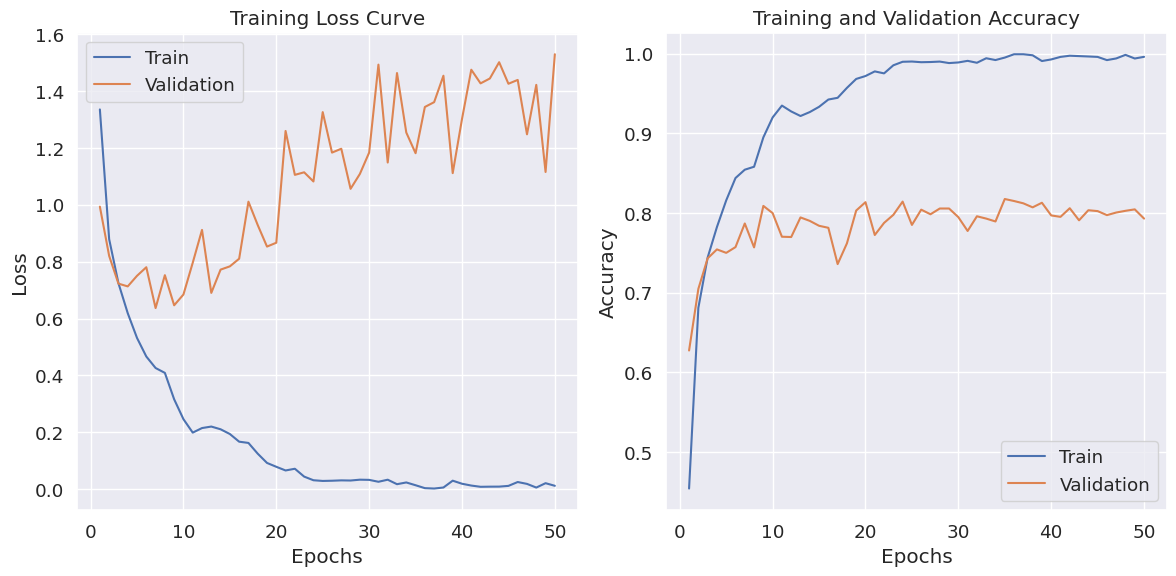

In [ ]:
# Set model and train
resnet50_deep = resnet50_deep_cnn()
train_and_eval_res(resnet50_deep, train_features_resnet50_deep, val_features_resnet50_deep, batch_size=128, lr=0.0001, epochs = 50, visualize=True)

In [ ]:
#save model to drive

!mv /content/model_resnet50_deep_bs128_lr0.0001_epoch35 /content/gdrive/MyDrive

In [ ]:
#get the best model

final_model = resnet50_deep_cnn()

final_model.load_state_dict(torch.load('/content/gdrive/MyDrive/model_resnet50_deep_bs128_lr0.0001_epoch35'))

<All keys matched successfully>

In [ ]:
x = test_model(final_model, test_features_resnet50_deep)
x = x*100
print(f"The test accuracy for the ResNet50 model is: {x:.4f}%")

The test accuracy for the ResNet50 model is: 82.2616%


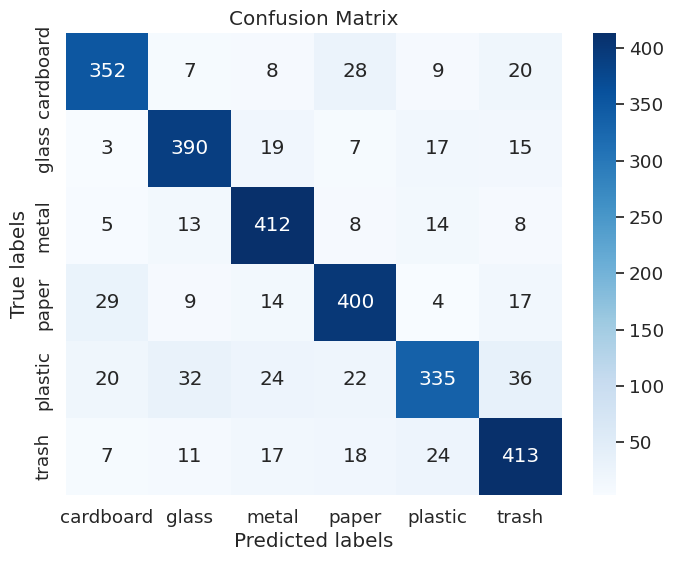

In [ ]:
confusionMatrix(final_model, val_features_resnet50_deep)

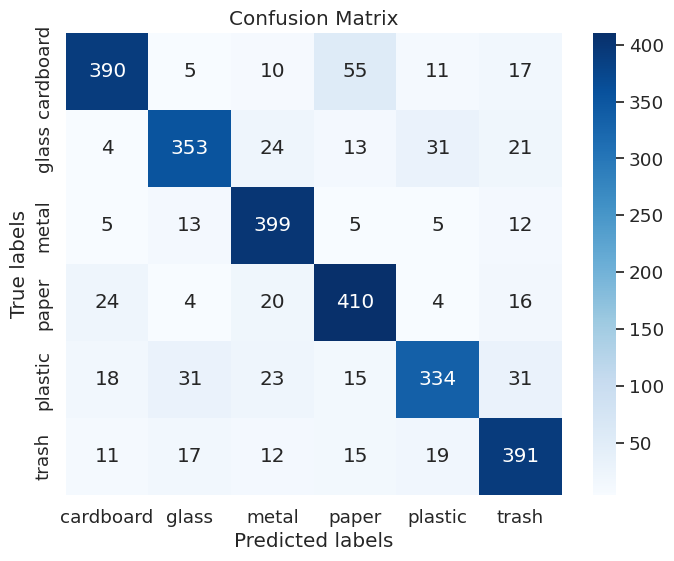

In [ ]:
confusionMatrix(final_model, test_features_resnet50_deep)